In [1]:
import torch
# 需命令行执行：
# pip install pytorch-nlp
import torchnlp
import torch.nn as nn
from torchnlp.word_to_vector import GloVe
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

# 模型定义（RNN模型）

In [2]:
num_time_steps = 50
input_size = 1
hidden_size = 16
output_size = 1
lr = 0.01

In [3]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )
        for p in self.rnn.parameters():
            nn.init.normal_(p, mean=0.0, std=0.001)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)
        # [batch_size, seq_len, hidden_size] -> [batch_size * seq_len, hidden_size]
        out = out.view(-1, hidden_size)
        # [batch_size * seq_len, hidden_size] -> [batch_size * seq_len, output_size]
        out = self.linear(out)
        # [batch_size * seq_len, output_size] -> [1, batch_size * seq_len, output_size] = [1, 1 * num_time_steps, output_size]
        out = out.unsqueeze(dim=0)
        return out, hidden_prev

In [4]:
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)
# [num_layers: 1, batch_size: 1, hidden_size: 16]
hidden_prev = torch.zeros(1, 1, hidden_size)

# 模型训练

In [5]:
# for iter in range(6000):
for iter in range(600):
    # np.random.randint(low, high=None, size=None, dtype='l')
    # 如果high为None，则low为最大值，生成的随机整数范围是[0, low)
    # 随机起始整数
    start = np.random.randint(3, size=1)[0]
    # 时间步
    time_steps = np.linspace(start, start + 10, num_time_steps)
    # 一维数据
    data = np.sin(time_steps)
    # 二维数据
    data = data.reshape(num_time_steps, 1)
    # 三维数据（上一个）[batch_size = 1, seq_len = num_time_steps - 1, word_vec = 1]
    x = torch.tensor(data[:-1]).float().view(1, num_time_steps - 1, 1)
    # 三维数据（下一个）[batch_size = 1, seq_len = num_time_steps - 1, word_vec = 1]
    y = torch.tensor(data[1:]).float().view(1, num_time_steps - 1, 1)
    # output: [1, 1 * num_time_steps - 1, 1]
    # hidden_prev: [1, 1, 16]
    output, hidden_prev = model(x, hidden_prev)
    # requires_grad改为false
    hidden_prev = hidden_prev.detach()
    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    # for p in model.parameters():
    #     print(p.grad.norm())
    # torch.nn.utils.clip_grad_norm_(p, 10)
    optimizer.step()
    if iter % 100 == 0:
        print("Iteration: {} loss {}".format(iter, loss.item()))

Iteration: 0 loss 0.5259910225868225
Iteration: 100 loss 0.013296027667820454
Iteration: 200 loss 0.003657276276499033
Iteration: 300 loss 0.004061360377818346
Iteration: 400 loss 0.002555051352828741
Iteration: 500 loss 0.00138002447783947


# 模型预测

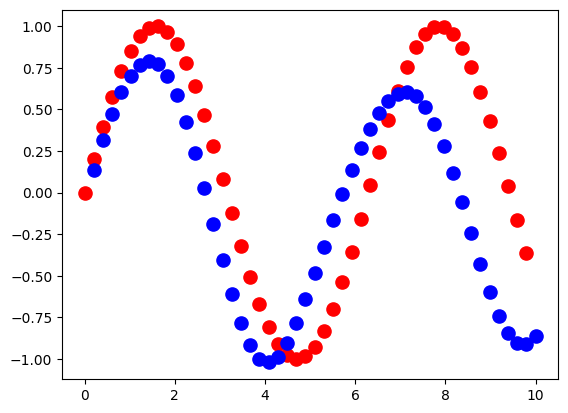

In [6]:
# 生成的随机整数范围是[0, 3)
start = np.random.randint(3, size=1)[0]
# 均分数组
time_steps = np.linspace(start, start + 10, num_time_steps)
# 生成数据
data = np.sin(time_steps)
data = data.reshape(num_time_steps, 1)
# 生成x（上一个数据）
x = torch.tensor(data[:-1]).float().view(1, num_time_steps - 1, 1)
# 生成y（下一个数据）
y = torch.tensor(data[1:]).float().view(1, num_time_steps - 1, 1)
predictions = []
# 第一个预测输入值
input = x[:, 0, :]
for _ in range(x.shape[1]):
    input = input.view(1, 1, 1)
    (pred, hidden_prev) = model(input, hidden_prev)
    # 上一个预测输出值，也是下一个预测输入值
    input = pred
    # 保存预测结果到predictions
    # ravel函数用于将多维数组展平为一维数组
    predictions.append(pred.detach().numpy().ravel()[0])
x = x.data.numpy().ravel()
y = y.data.numpy().ravel()
# 绘制x散点图
plt.scatter(time_steps[:-1], x.ravel(), s=90, c='r')
# 绘制x折线图
# plt.plot(time_steps[:-1], x.ravel())
# 绘制y散点图
# plt.scatter(time_steps[1:], y.ravel(), s=90, c='g')
# 绘制预测结果散点图
plt.scatter(time_steps[1:], predictions, s=90, c='b')
plt.show()